In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
! pip install opencv-python==3.4.11.45
! pip install opencv-contrib-python==3.4.11.45

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.4 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54.7 MB 154 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [4]:
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import random
import pandas as pd
from sklearn import metrics
from scipy.spatial.distance import cdist

In [5]:
#Get descriptors of keypoints in the image by using the SIFT Descriptor
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des
 #Stack descriptors together   
def stack(descriptor_list, clusters):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    kmeans = KMeans(n_clusters = clusters).fit(descriptors)
    ret =  KMeans(n_clusters = clusters).fit_predict(descriptors)
    __, ax = plt.subplots(2)

    ax[0].scatter(descriptors[:,0], descriptors[:,1])
    ax[0].set_title("Initial Scatter Distribution")
    ax[1].scatter(descriptors[:,0], descriptors[:,1], c=ret)
    ax[1].set_title("Colored Partition denoting Clusters")
    # plt.scatter
    plt.show()
    return kmeans 
#Extract features from the clusters of the descriptors  
def extractFeatures(kmeans, descriptor_list, image_count, clusters):
    zerosArray = np.zeros(clusters) #create a zero array of size equals to the number of clusters.
    features = np.array([zerosArray for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            index = kmeans.predict(feature)
            features[i][index] += 1
    return features
#Normalize extracted features so all of them exist on the same scale
def normalizeFeatures(scale, features):
    return scale.transform(features)

In [61]:
#Get path of the training and testing images and store images in images array
def getImages(data_path, data_type):
    categories = getFolderName(data_path)
    path = []
    imgdata = []
    img_path = []
    for category in categories:
     # print(category)
      path = category + data_type
     # print(path)
      text_file = open(path, "r") 
      data = text_file.readlines()
      text_file.close()
      #print(data)
      for i in data:
        i = i.strip('\n')
        img_arr = os.path.join(category,i) 
       # print(img_arr)
        img_array = plt.imread(img_arr)
        new_array = cv2.resize(img_array, (64, 64))
        cat = category.strip("/content/drive/MyDrive/A1 dataset")
        imgdata.append([new_array, cat])
        img_path.append(img_arr)
    img_path = np.array(img_path)    
    t_data = np.array(imgdata)
   # print(t_data)
    return t_data, img_path
def getImages2(data_path, data_type):
    categories = getFolderName(data_path)
    path = []
    catog = []
    imgdata = []
    img_path = []
    for category in categories:
     # print(category)
      path = category + data_type
     # print(path)
      text_file = open(path, "r") 
      data = text_file.readlines()
      text_file.close()
      #print(data)
      for i in data:
        i = i.strip('\n')
        img_arr = os.path.join(category,i) 
       # print(img_arr)
        img_array = plt.imread(img_arr)
        gray = rgb2gray(img_array)  
        new_array = cv2.resize(gray, (64, 64))
        cat = category.strip("/content/drive/MyDrive/A1 dataset")
        imgdata.append(new_array)
        catog.append(cat)
        img_path.append(img_arr)
    img_path = np.array(img_path)    
    t_data = np.array(imgdata)
    catog = np.array(catog)
   # print(t_data)
    return t_data, img_path,catog    
def classifier(im_features, train_labels,clf):
  if(clf == "Rand"):
    clas = RandomForestClassifier(n_estimators=100)
  elif(clf == "Logist"):  
    clas = LogisticRegression()
  elif(clf == "NB"):  
    clas = GaussianNB()
  clas.fit(im_features, train_labels)
  return clas  
def unsupervisedCLF(X, total_clusters):
  #total_clusters = len(np.unique(y_test))
  # Initialize the K-Means model
  kmeanModel = KMeans(n_clusters=total_clusters).fit(X)
  ret =  KMeans(n_clusters = total_clusters).fit_predict(X)
  __, ax = plt.subplots(2)

  ax[0].scatter(X[:,0], X[:,1])
  ax[0].set_title("Initial Scatter Distribution")
  ax[1].scatter(X[:,0], X[:,1], c=ret)
  ax[1].set_title("Colored Partition denoting Clusters")
  # plt.scatter
  plt.show()
  kmeanModel.fit(X)
  return kmeanModel
def testUnsupervised(path, dataType, kmeanModel):
  images,img_path,y_labels = getImages2(path, dataType)
  print(images.shape)
  X_test = images.reshape(len(images),-1)
  print(X_test.shape)
  pred = kmeanModel.predict(X_test)  
  return pred, y_labels, img_path
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])     

In [7]:
def getFolderName(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(getFolderName(dirname))
    return subfolders
def elbow(path, dataType):
  images,img_path,y_labels = getImages2(path, dataType)
  print(images.shape)
  X = images.reshape(len(images),-1)
  print(X.shape)
  #clf = unsupervisedCLF(X_train, clusters)
  distortions = []
  inertias = []
  mapping1 = {}
  mapping2 = {}
  K = range(1, 15)
    
  for k in K:
      # Building and fitting the model
      kmeanModel = KMeans(n_clusters=k).fit(X)
      kmeanModel.fit(X)
    
      distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                          'euclidean'), axis=1)) / X.shape[0])
      inertias.append(kmeanModel.inertia_)
    
      mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0]
      mapping2[k] = kmeanModel.inertia_    
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method using Distortion')
  plt.show()
  return X  


In [36]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
def plotHistogram(im_features, clusters):
    x_scalar = np.arange(clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Index")
    plt.ylabel("Frequency")
    plt.title("Visual Bag of Words")
    plt.xticks(x_scalar, x_scalar, color="black")
    plt.show()

def plotConfusions(true, predictions):
    class_names = ['0','1','2','3','4','5','6','7','8','9']
    print(classification_report(true, predictions, target_names=class_names))
    cnf_matrix = confusion_matrix(true, predictions)
    cm = confusion_matrix(true,predictions)
    print_confusion_matrix(cm,class_names)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

# Sensitivity,  recall, or true positive rate
    TPR = TP/(TP+FN)
    print(TPR, "true positive rate")
# Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print(TNR, "true negative rate")
# false positive rate
    FPR = FP/(FP+TN)
    print(FPR, "false positive rate")
# False negative rate
    FNR = FN/(TP+FN)
    print(FNR, "False negative rate")
# Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print(ACC)

def Accuracy(true, predictions):
    print ('Testing Accuracy: %0.3f' % accuracy_score(true, predictions))

In [9]:
def trainModel(path, data_type, classif, desc):
    #path = "/content/drive/MyDrive/TrainingData"
    clusters = 150
    images,img_path = getImages(path, data_type)
    print(images.shape)
    #sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    label_count = 10
    image_count = len(images)
    train_labels = np.array([])
    #for img_path in images:
    X = []
    y = []
    for features, label in images:
        #X.append(features)
        #print(label)
        y.append(label)
        X = np.array(X).reshape(-1, 64, 64, 3)
        train_labels = np.append(train_labels, y)
        #img = readImage(img_path)
        des = getDescriptors(desc, features)
        descriptor_list.append(des)

    kmeans = stack(descriptor_list, clusters)
    
    im_features = extractFeatures(kmeans, descriptor_list, image_count, clusters)
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    plotHistogram(im_features, clusters)
    clf = classifier(im_features, y,classif)
    #clf = unsupervisedCLF(im_features)
    return kmeans, scale, clf, im_features

In [44]:
lbl =	{ "0": "0","2": "2","3": "3","4": "4","5": "5","6": "6","7": "7","8": "8","9": "9","": ""
    }
def testModel( kmeans, scale, clf, im_features, path, data_type):
    #path = "/content/drive/MyDrive/TestingData"
    test_images,img_path = getImages(path, data_type )
    clusters = 150
    count = 0
    true = []
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    X = []
    y = []
    for features, label in test_images:
     y.append(label)
     #print(y)
     X = np.array(X).reshape(-1, 64, 64, 3)
     des = getDescriptors(sift, features)
     if(des is not None):
         count += 1
         descriptor_list.append(des)   
    test_features = extractFeatures(kmeans, descriptor_list, count, clusters)
    test_features = scale.transform(test_features)  
    #print(lbl[str(int(i))] for i in clf.predict(test_features))
    predictions = [lbl[str(i)] for i in clf.predict(test_features)]
    plotConfusions(np.array(y, dtype=np.string_),np.array(predictions, dtype=np.string_))
    #print ('Accuracy of testing data' % accuracy_score(true, predictions))
    Accuracy(np.array(y, dtype=np.string_),np.array(predictions, dtype=np.string_))
    print(predictions)
    return img_path, predictions,y

In [11]:
def incorrect_correctImages(img_path,ground_truth,predictions):
  for i in range(10):
    a = random.randint(0,200)
    img_paths = img_path[a]
    img_array = plt.imread(img_paths)
    new_array = cv2.resize(img_array, (64, 64))
    imgplot = plt.imshow(new_array)
    plt.show()
    z = ground_truth[a] == predictions[a]
    if(z == 0):
      #e = str(ground_truth[a])
      print (str("Inccorect classification- True label ")+ str(ground_truth[a]) + str("predicted label ")+ str(predictions[a]))
    elif(z==1): 
      print (str("Correctly classified")+ str(ground_truth[a])) 

**Train Model Using Sift as feature Extractor and Logistic Regression as Classifier**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(800, 2)


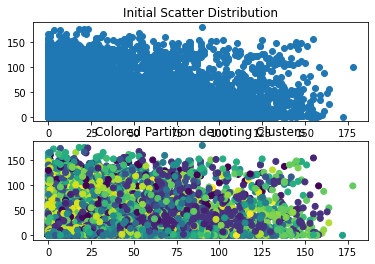

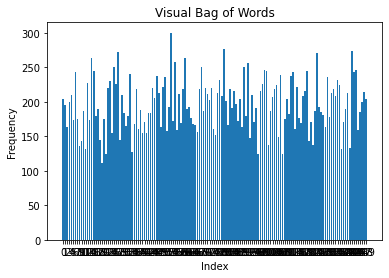

In [47]:
sift = cv2.xfeatures2d.SIFT_create()
kmeans, scale, clf, im_features = trainModel("/content/drive/MyDrive/A1 dataset", "/train.txt",'Logist',sift)

**Test Model Using Sift as feature Extractor and Logistic Regression as Classifier**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        20
           1       0.82      0.90      0.86        20
           2       1.00      1.00      1.00        20
           3       1.00      0.90      0.95        20
           4       1.00      0.95      0.97        20
           5       0.95      1.00      0.98        20
           6       0.83      0.75      0.79        20
           7       0.77      0.85      0.81        20
           8       1.00      0.80      0.89        20
           9       1.00      1.00      1.00        20

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

[1.   0.9  1.   0.9  0.95 1.   0.75 0.85 0.8  1.  ] true positive rate
[0.97777778 0.97777778 1.         1.         1.         0.99444444
 0.98333333 0.97222222 1.         1.        ] true negative rate
[0.02222222 0.02222222 0.         0.  

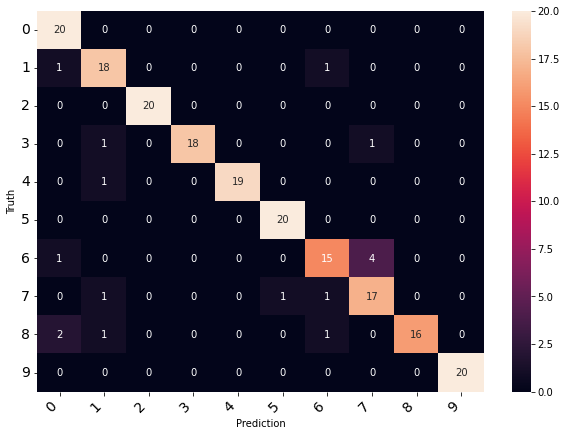

In [48]:
img_path, predictions,ground_truth = testModel( kmeans, scale, clf, im_features, "/content/drive/MyDrive/A1 dataset", "/test.txt")

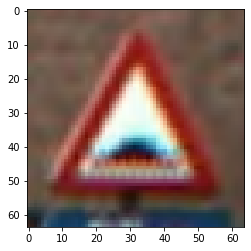

Inccorect classification- True label 0predicted label 7


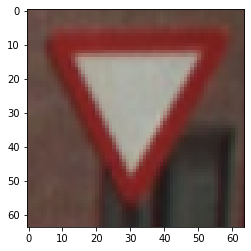

Correctly classified6


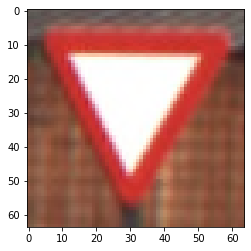

Correctly classified6


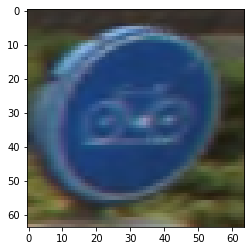

Correctly classified8


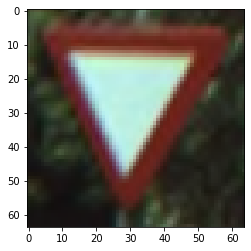

Inccorect classification- True label 6predicted label 7


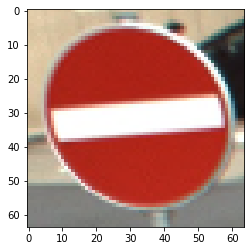

Correctly classified5


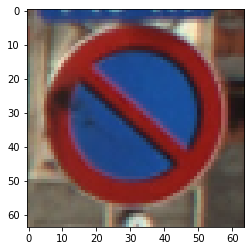

Correctly classified


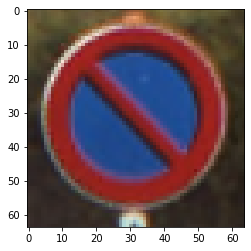

Correctly classified


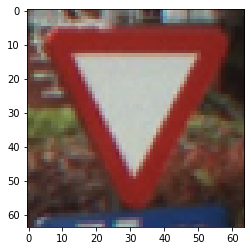

Correctly classified6


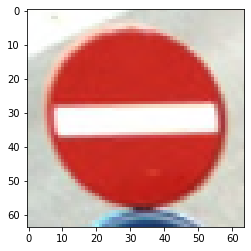

Correctly classified5


In [15]:
incorrect_correctImages(img_path,ground_truth,predictions)

**Train Model Using Sift as feature Extractor and Random Forest as Classifier**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(800, 2)


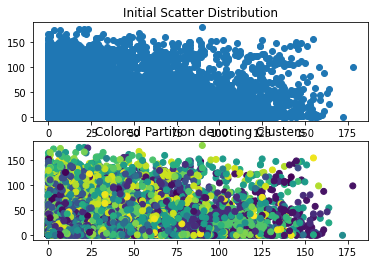

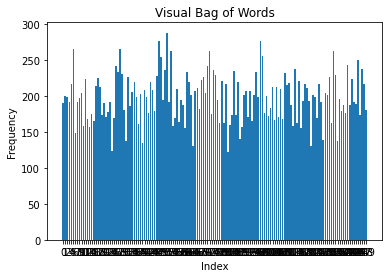

In [49]:
sift = cv2.xfeatures2d.SIFT_create()
kmeans, scale, clf, im_features = trainModel("/content/drive/MyDrive/A1 dataset", "/train.txt",'Rand',sift)

**Test Model Using Sift as feature Extractor and Random Forest as Classifier**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.90      0.95        20
           2       1.00      1.00      1.00        20
           3       0.95      0.95      0.95        20
           4       0.95      1.00      0.98        20
           5       1.00      1.00      1.00        20
           6       0.76      0.65      0.70        20
           7       0.72      0.90      0.80        20
           8       1.00      0.90      0.95        20
           9       1.00      1.00      1.00        20

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200

[1.   0.9  1.   0.95 1.   1.   0.65 0.9  0.9  1.  ] true positive rate
[0.99444444 1.         1.         0.99444444 0.99444444 1.
 0.97777778 0.96111111 1.         1.        ] true negative rate
[0.00555556 0.         0.         0.00555556 0

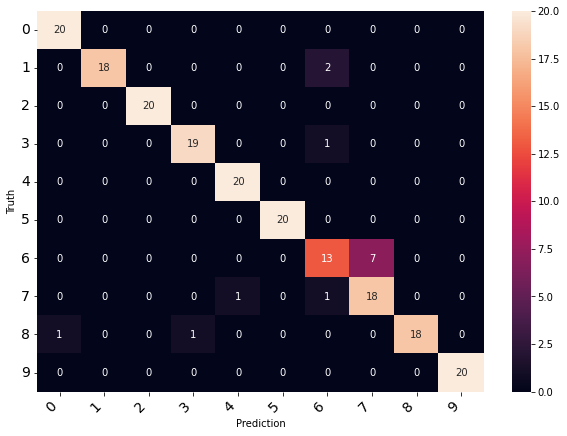

In [50]:
img_path, predictions,ground_truth = testModel( kmeans, scale, clf, im_features, "/content/drive/MyDrive/A1 dataset", "/test.txt")

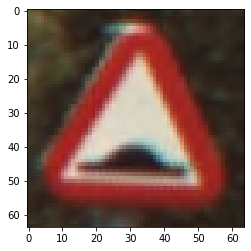

Correctly classified0


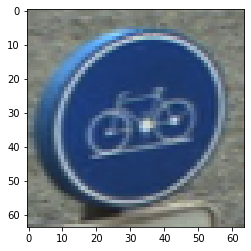

Correctly classified8


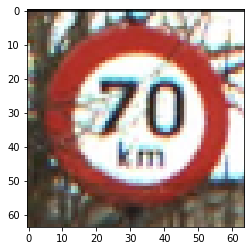

Correctly classified2


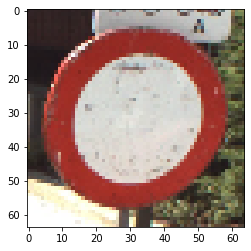

Correctly classified7


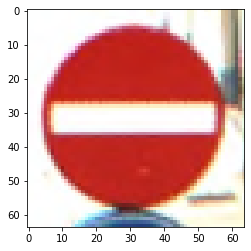

Correctly classified5


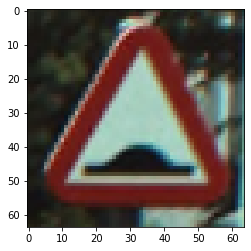

Correctly classified0


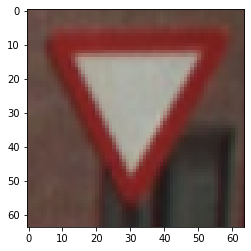

Correctly classified6


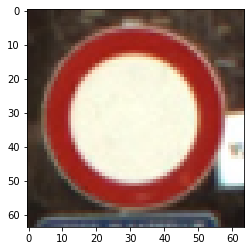

Correctly classified7


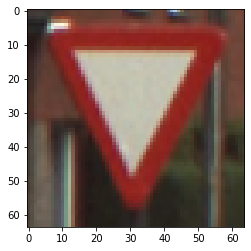

Inccorect classification- True label 6predicted label 7


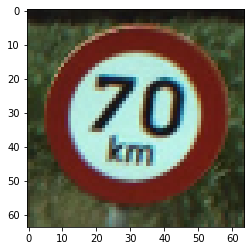

Correctly classified2


In [18]:
incorrect_correctImages(img_path,ground_truth,predictions)

**Train Model Using Sift as feature Extractor and Naive Bayes as Classifier**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(800, 2)


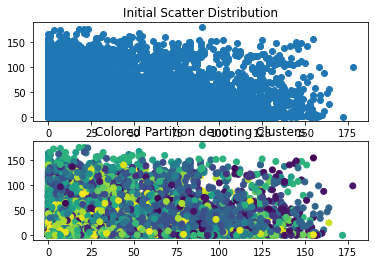

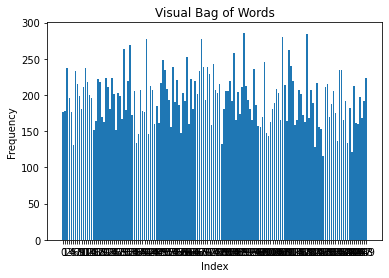

In [39]:
sift = cv2.xfeatures2d.SIFT_create()
kmeans, scale, clf, im_features = trainModel("/content/drive/MyDrive/A1 dataset", "/train.txt",'NB',sift)

**Test Model Using Sift as feature Extractor and Naive Bayes as Classifier**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.71      0.75      0.73        20
           2       0.91      1.00      0.95        20
           3       0.90      0.95      0.93        20
           4       1.00      1.00      1.00        20
           5       0.62      0.90      0.73        20
           6       0.71      0.50      0.59        20
           7       0.61      0.55      0.58        20
           8       1.00      0.80      0.89        20
           9       0.89      0.80      0.84        20

    accuracy                           0.80       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200

[0.75 0.75 1.   0.95 1.   0.9  0.5  0.55 0.8  0.8 ] true positive rate
[0.96666667 0.96666667 0.98888889 0.98888889 1.         0.93888889
 0.97777778 0.96111111 1.         0.98888889] true negative rate
[0.03333333 0.03333333 0.01111111 0.01

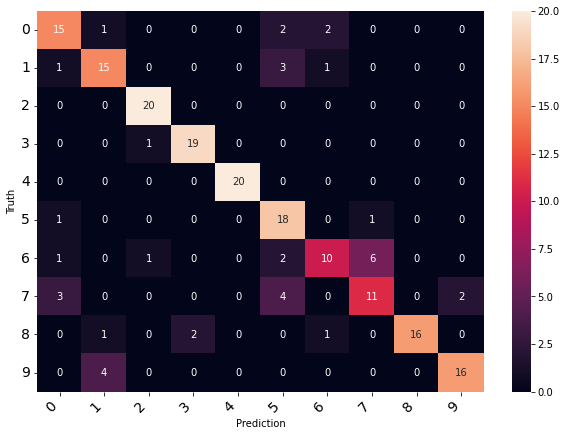

In [46]:
img_path, predictions,ground_truth = testModel( kmeans, scale, clf, im_features, "/content/drive/MyDrive/A1 dataset", "/test.txt")

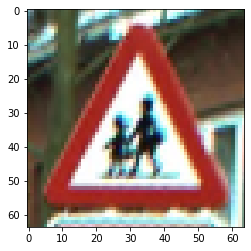

Correctly classified4


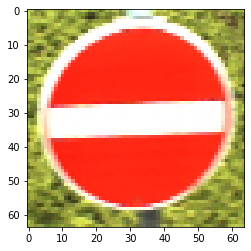

Inccorect classification- True label 5predicted label 8


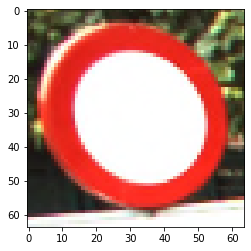

Correctly classified7


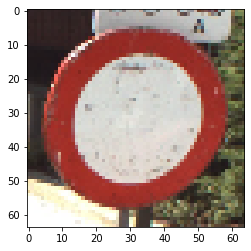

Inccorect classification- True label 7predicted label 3


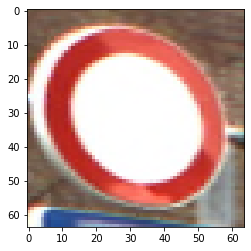

Inccorect classification- True label 7predicted label 9


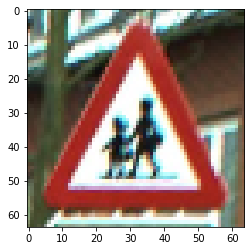

Correctly classified4


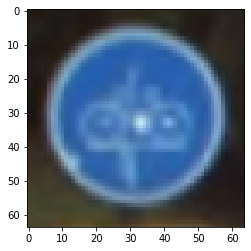

Correctly classified8


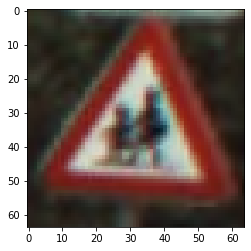

Correctly classified4


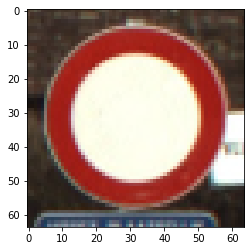

Correctly classified7


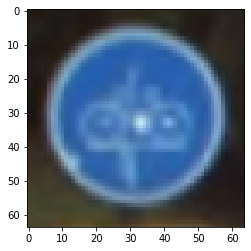

Correctly classified8


In [21]:
incorrect_correctImages(img_path,ground_truth,predictions)

**Unsupervised Paradigm**

**Check optimal clusters by using Elbow method**

(800, 64, 64)
(800, 4096)


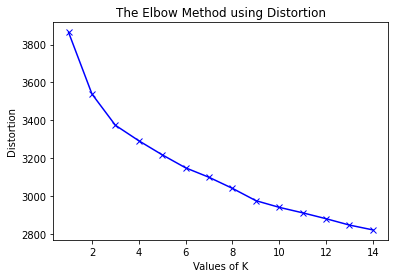

In [22]:
X = elbow("/content/drive/MyDrive/A1 dataset", "/train.txt")

**K should be either 10 or 11**

**Train K-Means Model with 10 clusters**

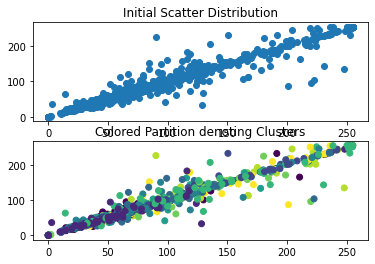

In [62]:
kmeans = unsupervisedCLF(X,10)

In [24]:
pred, y_labels, img_path = testUnsupervised( "/content/drive/MyDrive/A1 dataset", "/test.txt", kmeans)

(200, 64, 64)
(200, 4096)


In [25]:
for i in range(200):
  if(y_labels[i] == ''):
    print(y_labels[i])
    x = y_labels[i]
    y_labels[i] = x.replace('', '1' )


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           2       0.26      0.45      0.33        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20
           6       0.50      0.30      0.37        20
           7       0.00      0.00      0.00        20
           8       0.16      0.15      0.15        20
           9       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20

    accuracy                           0.09       200
   macro avg       0.09      0.09      0.09       200
weighted avg       0.09      0.09      0.09       200

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.26      0.45      0.33        20
           2       0.00      0.00      0.00        20
           3       0.00 

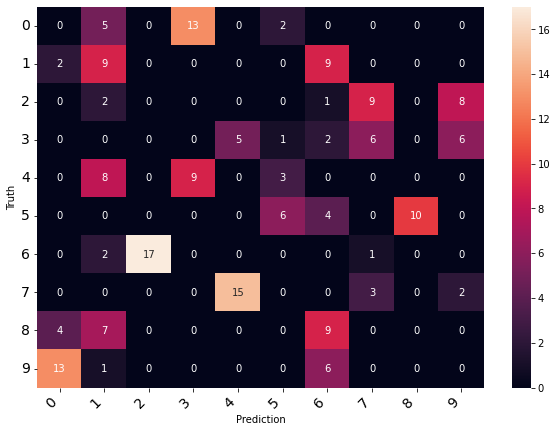

In [29]:
lbl = { "0": "0","2": "2","3": "3","4": "4","5": "5","6": "6","7": "7","8": "8","9": "9","1": "1"
    }
pred = np.array(pred).astype(str)    
print(classification_report(y_labels, pred, target_names=lbl))
plotConfusions(np.array(y_labels, dtype=np.string_),np.array(pred, dtype=np.string_))

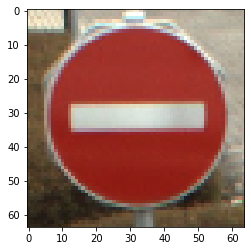

Inccorect classification- True label 5predicted label 6


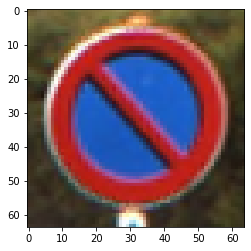

Correctly classified1


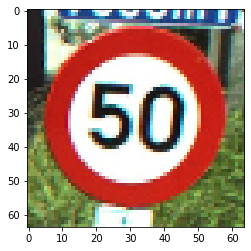

Inccorect classification- True label 3predicted label 9


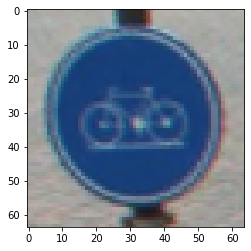

Inccorect classification- True label 8predicted label 6


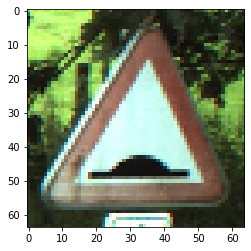

Inccorect classification- True label 0predicted label 3


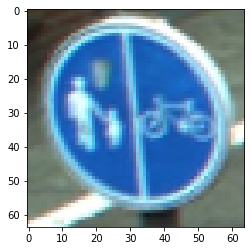

Inccorect classification- True label 9predicted label 6


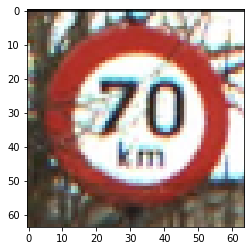

Inccorect classification- True label 2predicted label 9


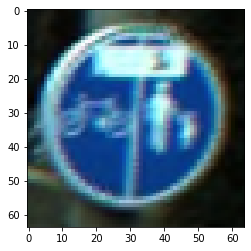

Inccorect classification- True label 9predicted label 0


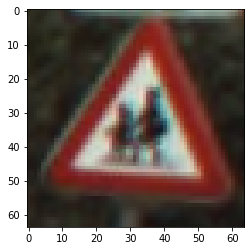

Inccorect classification- True label 4predicted label 1


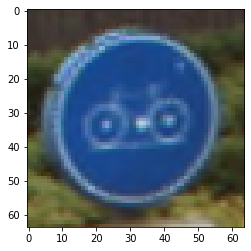

Inccorect classification- True label 8predicted label 1


In [30]:
incorrect_correctImages(img_path,y_labels,pred)

In [51]:
def trainModel2(path, data_type, desc):
    #path = "/content/drive/MyDrive/TrainingData"
    clusters = 150
    images,img_path = getImages(path, data_type)
    print(images.shape)
    #sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    label_count = 10
    image_count = len(images)
    train_labels = np.array([])
    #for img_path in images:
    X = []
    y = []
    for features, label in images:
        #X.append(features)
        #print(label)
        y.append(label)
        X = np.array(X).reshape(-1, 64, 64, 3)
        train_labels = np.append(train_labels, y)
        #img = readImage(img_path)
        des = getDescriptors(desc, features)
        descriptor_list.append(des)

    kmeans = stack(descriptor_list, clusters)
    
    im_features = extractFeatures(kmeans, descriptor_list, image_count, clusters)
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    plotHistogram(im_features, clusters)
    #clf = classifier(im_features, y,classif)
    clf = unsupervisedCLF(im_features, 10)
    return kmeans, scale, clf, im_features

In [52]:
lbl =	{ "0": "0","2": "2","3": "3","4": "4","5": "5","6": "6","7": "7","8": "8","9": "9","": ""
    }
def testModel( kmeans, scale, clf, im_features, path, data_type):
    #path = "/content/drive/MyDrive/TestingData"
    test_images,img_path = getImages(path, data_type )
    clusters = 150
    count = 0
    true = []
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    X = []
    y = []
    for features, label in test_images:
     y.append(label)
     #print(y)
     X = np.array(X).reshape(-1, 64, 64, 3)
     des = getDescriptors(sift, features)
     if(des is not None):
         count += 1
         descriptor_list.append(des)   
    test_features = extractFeatures(kmeans, descriptor_list, count, clusters)
    test_features = scale.transform(test_features)  
    #print(lbl[str(int(i))] for i in clf.predict(test_features))
    for i in range(200):
      if(y[i] == ''):
        print(y[i])
        x = y[i]
        y[i] = x.replace('', '1' )
    predictions = clf.predict(test_features)
    plotConfusions(np.array(y, dtype=np.string_),np.array(predictions, dtype=np.string_))
    #print ('Accuracy of testing data' % accuracy_score(true, predictions))
    Accuracy(np.array(y, dtype=np.string_),np.array(predictions, dtype=np.string_))
    print(predictions)
    return img_path, predictions,y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(800, 2)


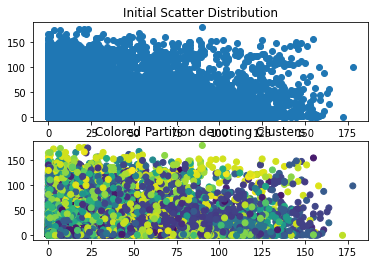

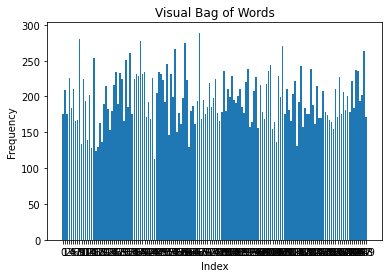

In [53]:
sift = cv2.xfeatures2d.SIFT_create()
kmeans, scale, clf, im_features = trainModel2("/content/drive/MyDrive/A1 dataset", "/train.txt",sift)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.






















              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       1.00      1.00      1.00        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20
           6       0.22      0.85      0.35        20
           7       0.00      0.00      0.00        20
           8       1.00      0.55      0.71        20
           9       0.00      0.00      0.00        20

    accuracy                           0.24       200
   macro avg       0.22      0.24      0.21       200
weighted avg       0.22      0.24      0.21       200

[0.   0.   1.   0.   0.   0.   0.85 0.   0.55 0.  ] true positive rate
[1.         0.88888889 1.         0.88888889 0.91111111 0.92222222
 0.66111111 0.92222222 1.         0.96111111] true negative rate
[0.         0.1111

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


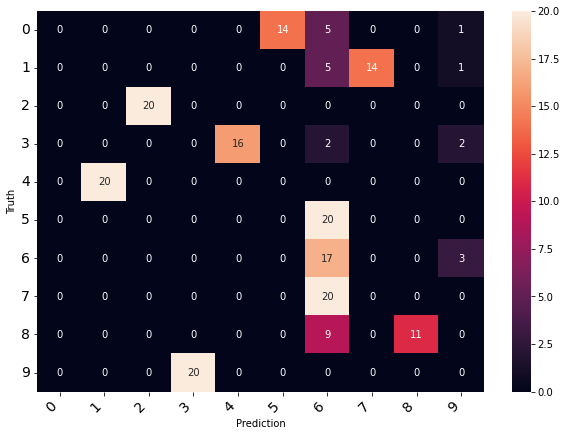

In [54]:
img_path, predictions,ground_truth = testModel( kmeans, scale, clf, im_features, "/content/drive/MyDrive/A1 dataset", "/test.txt")

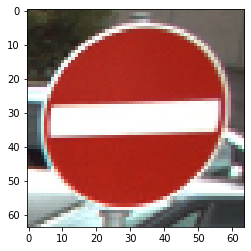

Inccorect classification- True label 5predicted label 6


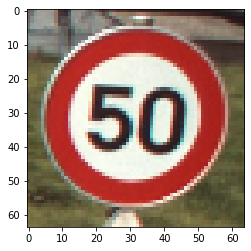

Inccorect classification- True label 3predicted label 4


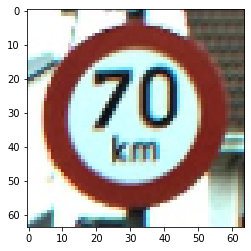

Inccorect classification- True label 2predicted label 2


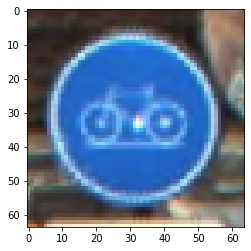

Inccorect classification- True label 8predicted label 8


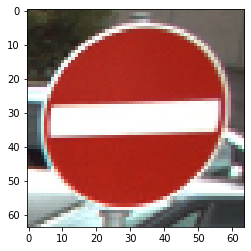

Inccorect classification- True label 5predicted label 6


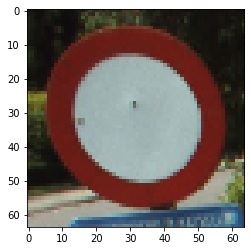

Inccorect classification- True label 7predicted label 6


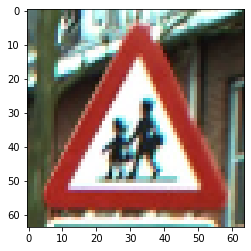

Inccorect classification- True label 4predicted label 1


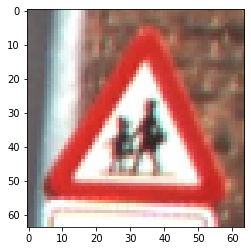

Inccorect classification- True label 4predicted label 1


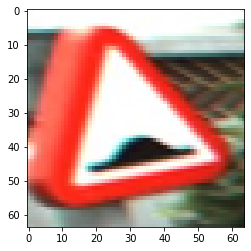

Inccorect classification- True label 0predicted label 5


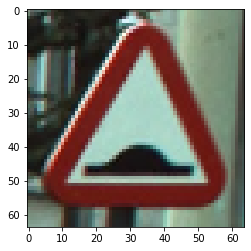

Inccorect classification- True label 0predicted label 5


In [55]:
incorrect_correctImages(img_path,ground_truth,predictions)
